In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

%aimport deepsvr

Populating the interactive namespace from numpy and matplotlib


In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

from analysis_utils.ClassifierPlots import create_reliability_diagram, create_roc_curve, create_feature_importance_plot
from analysis_utils.Analysis import print_accuracy_and_classification_report, predict_classes, get_somatic_error_type

sns.set_style("white")
sns.set_context('poster')

In [4]:
# Pull in training data
training_data = pd.read_pickle('deepsvr/data/training_data_preprocessed.pkl')
training_data.sort_index(axis=1, inplace=True)

In [5]:
# Remove AML31 case
aml31_training = training_data[training_data.index.str.contains('fSsMNn1DZ3AIDGk=')]
training_data = training_data[~training_data.index.str.contains('fSsMNn1DZ3AIDGk=')]

In [6]:
# Show the calls associate with training data
training_data.groupby('call').size()

call
a    10643
f     8854
g     3122
s    18381
dtype: int64

In [7]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# Somatic, ambigous, fail classifier

In [8]:
# Re-label the germline calls as failed calls
three_class = training_data.replace('g','f')
three_class.sort_index(axis=1, inplace=True)

In [9]:
# Show the calls associate with training data
three_class.groupby('call').size()

call
a    10643
f    11976
s    18381
dtype: int64

In [10]:
# Get labels for training data
Y = three_class.call.values
# Get training data as numpy array
X = training_data.drop(['call'], axis=1).astype(float).values

In [11]:
# Split the data for cross-validation
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.33, random_state=seed)

In [12]:
# print(Y_train)
# print(X_train)

In [13]:
# Determine shape of training data features for cross-validation
X_train.shape

(27470, 71)

In [14]:
# Determine shape of training data calls for cross-validation
Y_train.shape

(27470,)

In [15]:
# Set parameters for the Random Forest Model
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
enc = preprocessing.MultiLabelBinarizer()
Y_one_hot = enc.fit_transform(Y_train)

In [61]:
# # Perform cross validation and pull AUC for various splits
# # This is commented out after vinding 'optimal' values to faster reproducibility
# auc = []
# for n in [100, 1000, 10000]:
#     est = RandomForestClassifier(n_estimators=n, max_features=8,n_jobs=-1, 
#                                  oob_score=True)
#     probs = cross_val_predict(est, X_train, Y_train, cv=kfold, method='predict_proba')
#     temp_auc = []
#     for j in range(Y_one_hot.shape[1]):
#         temp_auc.append(metrics.roc_auc_score(Y_one_hot[:, j], probs[:, j]))
#     auc.append(temp_auc)
#     print('Test AUC for {0} trees: '.format(n), temp_auc)
#     print('---------------------------------------------------------')

In [17]:
# Set parameters for the extimator
estimator = RandomForestClassifier(n_estimators=100, max_features=8, 
                                   n_jobs=-1, oob_score=True)

In [18]:
# Perform cross validation
probabilities = cross_val_predict(estimator, X_train, Y_train, cv=kfold, method='predict_proba')

In [19]:
# # Save the probabilities in /data folder
# np.save('../data/random_forest/1000estimators.npy', probabilities)

In [20]:
print(probabilities)
print(Y_one_hot)
print(predict_classes(probabilities))

[[0.13 0.41 0.46]
 [0.07 0.04 0.89]
 [0.2  0.72 0.08]
 ...
 [0.82 0.   0.18]
 [0.   0.   1.  ]
 [0.87 0.01 0.12]]
[[0 1 0]
 [0 0 1]
 [0 1 0]
 ...
 [1 0 0]
 [0 0 1]
 [1 0 0]]
[[0 0 1]
 [0 0 1]
 [0 1 0]
 ...
 [1 0 0]
 [0 0 1]
 [1 0 0]]


#### Classification report
* 0 = ambiguous
* 1 = fail
* 2 = somatic

In [21]:
# print accuracy report
print_accuracy_and_classification_report(Y_one_hot, predict_classes(probabilities))

Cross validation accuracy:
	 0.8918092464506735

Cross validation classification report

              precision    recall  f1-score   support

           0       0.85      0.79      0.81      7189
           1       0.92      0.92      0.92      8015
           2       0.90      0.94      0.92     12266

   micro avg       0.89      0.89      0.89     27470
   macro avg       0.89      0.88      0.88     27470
weighted avg       0.89      0.89      0.89     27470
 samples avg       0.89      0.89      0.89     27470



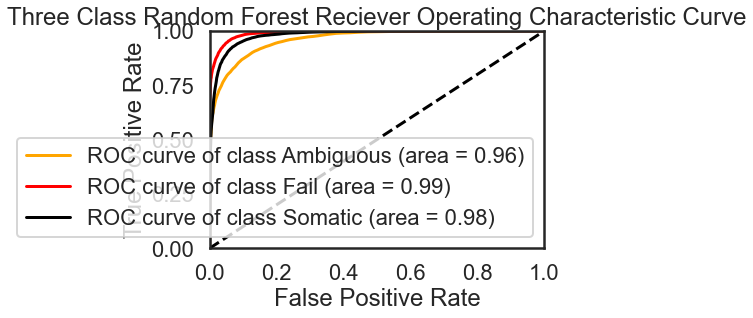

In [22]:
# Plot ROC for Random Forest Model
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
fig, ax = plt.subplots()
create_roc_curve(Y_one_hot, probabilities, class_lookup, 'Three Class Random'
                 ' Forest Reciever Operating Characteristic Curve', ax)

confidence intervals +-:  [0.00089047 0.00343957 0.00600189 0.00832483 0.00948002 0.00992829
 0.00918952 0.00647337 0.00407779 0.00074926]


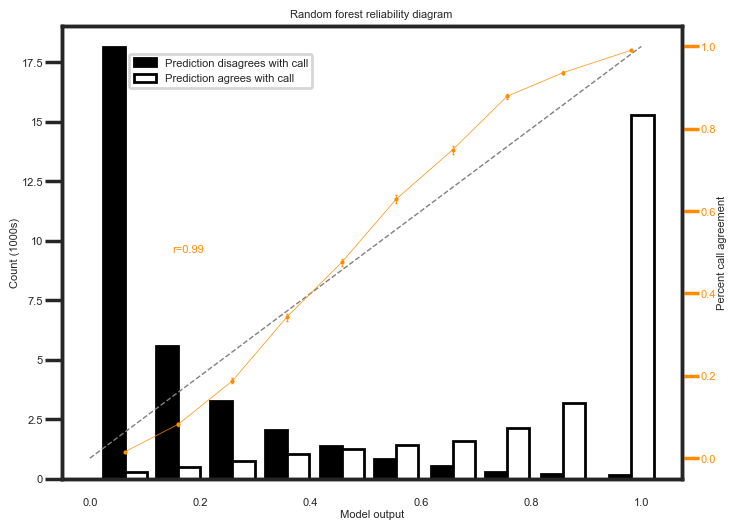

In [23]:
# Plot reliability diagram for Random Forest Model
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
lgd = create_reliability_diagram(probabilities, Y_one_hot,['Ambiguous','Fail','Somatic'], 'darkorange', 'Random forest reliability diagram',
                                 ax, True, True, True)
lgd.set_bbox_to_anchor((0.1, .85))

## Feature importance analysis

In [24]:
# Rebuild random forest model
forest = estimator.fit(X_train, Y_train)

In [25]:
# Sum the feature importance metrics for one-hot encoded variables
# (Feature importance calculation in scikit-learn is outlined 
# here https://stackoverflow.com/a/15821880/3862525).
# Since the importances are calculated with the same denominator, summing is
# appropriate
def sum_features(feature_import, label):
    starts_with_label = feature_import.feature.str.startswith(label)
    return feature_import.importance[starts_with_label].sum()

In [26]:
# Create function to determine the feature importance 
def create_feature_importance_plot(trained_model, save_fp='deepsvr/data/random_forest/feature_import.pkl'):
    feature_import = pd.DataFrame([training_data.drop(['call'], axis=1).columns.values,trained_model.feature_importances_]).T
    feature_import.columns = ['feature', 'importance']
    summed_importances = []
    for label in ['disease', 'reviewer']:
        summed_importances.append([label, sum_features(feature_import, label)])
    summed_importances = pd.DataFrame(summed_importances, columns=['feature','importance'])
    feature_import.to_pickle(save_fp)
    feature_import.sort_values('importance', ascending=False, inplace=True)
    feature_import.replace({'feature':{'var':'variant','ref':'reference', 'avg':'average', '_se_':'_single_end_', '3p':'3_prime', '_':' '}}, regex=True, inplace=True)
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.barplot(y='feature', x='importance', data=feature_import.head(30), color='darkorange')
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    plt.title('Random forest feature importance')

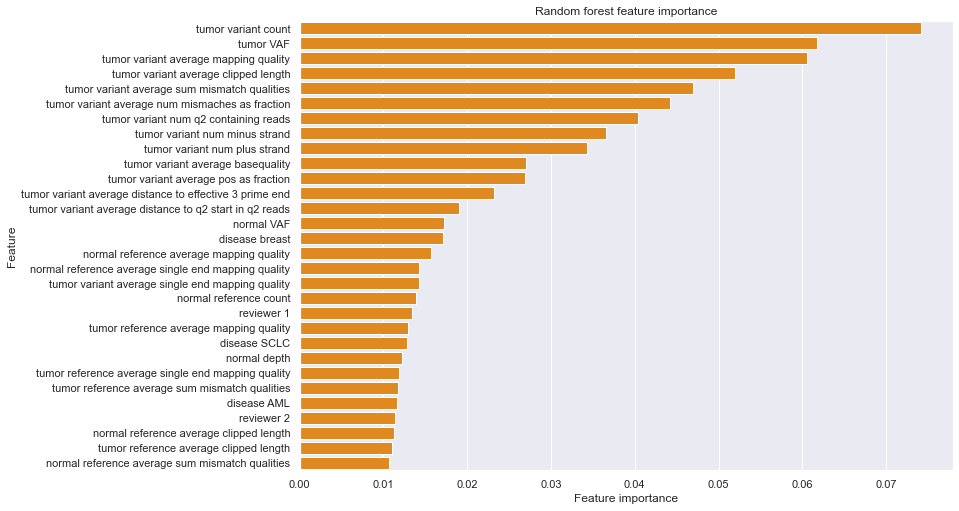

In [27]:
# Plot feature importance graph
create_feature_importance_plot(forest)

### Test set performance

In [28]:
# Determine performance on test set
test_prob = forest.predict_proba(X_test)

In [29]:
# Transform labels for predictions
Y_test_labels = enc.fit_transform(Y_test)

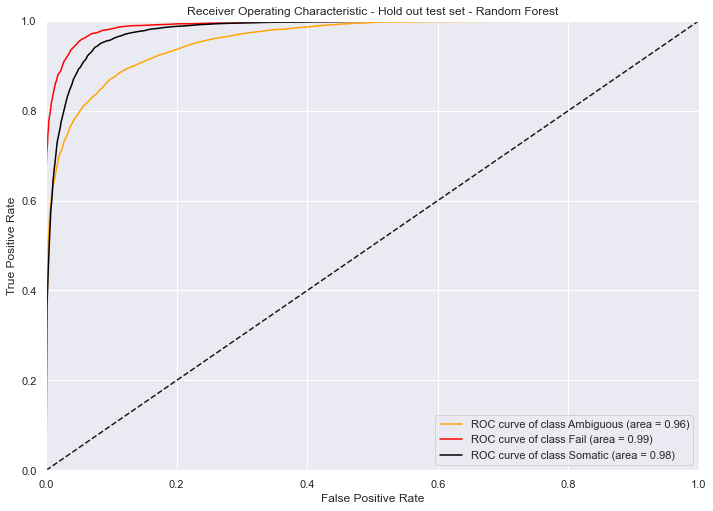

In [30]:
# Plot AUC for test set
fig, ax = plt.subplots()
create_roc_curve(Y_test_labels, test_prob, class_lookup, 'Receiver Operating '
                 'Characteristic - Hold out test set - '
                 'Random Forest', ax)

confidence intervals +-:  [0.00125867 0.00489683 0.00829781 0.01196889 0.01381878 0.01427103
 0.01270817 0.00939398 0.00587862 0.00107719]


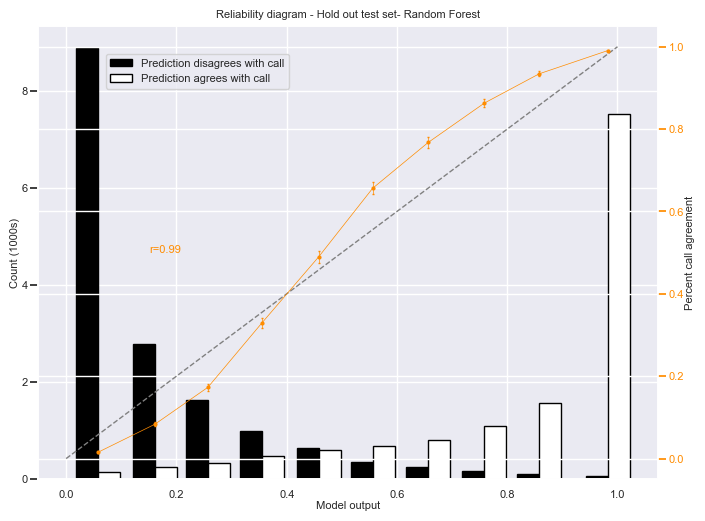

In [31]:
# Plot reliability diagram for test set
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
lgd = create_reliability_diagram(test_prob, Y_test_labels,
                                 ['Ambiguous','Fail','Somatic'], 
                                 'darkorange', 'Reliability diagram - Hold out test set'
                                 '- Random Forest',
                                 ax, True, True, True)
lgd.set_bbox_to_anchor((0.1, .85))

## Solid vs blood tumor

In [32]:
# Colapse disease types into solid vs liquid tumors
s_v_b = three_class
s_v_b['solid_tumor'] = s_v_b[['disease_GST', 'disease_MPNST', 'disease_SCLC',
                              'disease_breast', 'disease_colorectal', 
                              'disease_glioblastoma', 'disease_melanoma']].apply(any, axis=1).astype(int)
s_v_b.drop(['disease_AML', 'disease_GST', 'disease_MPNST', 'disease_SCLC',
       'disease_breast', 'disease_colorectal', 'disease_glioblastoma',
       'disease_lymphoma', 'disease_melanoma'], axis=1, inplace=True)

In [33]:
# Determine shape of new data set
s_v_b.groupby('call').size()

call
a    10643
f    11976
s    18381
dtype: int64

In [34]:
# Get Labels
Y = s_v_b.call.values
# Get training data as numpy array
X = s_v_b.drop(['call'], axis=1).astype(float).values

In [35]:
# Split data into training set and test set
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.33, random_state=seed)

In [36]:
# Determine shape
X_train.shape

(27470, 63)

In [37]:
# Determine shape
Y_train.shape

(27470,)

In [38]:
# Determine cross validation probabilites
probabilities = cross_val_predict(estimator, X_train, Y_train, cv=kfold, method='predict_proba')

#### Classification report
* 0 = ambiguous
* 1 = fail
* 2 = somatic

In [39]:
# Show accuracy profile of the cross-validation
enc = preprocessing.MultiLabelBinarizer()
Y_one_hot = enc.fit_transform(Y_train)
print_accuracy_and_classification_report(Y_one_hot, predict_classes(probabilities))

Cross validation accuracy:
	 0.8890789952675646

Cross validation classification report

              precision    recall  f1-score   support

           0       0.84      0.78      0.81      7189
           1       0.91      0.91      0.91      8015
           2       0.90      0.94      0.92     12266

   micro avg       0.89      0.89      0.89     27470
   macro avg       0.88      0.88      0.88     27470
weighted avg       0.89      0.89      0.89     27470
 samples avg       0.89      0.89      0.89     27470



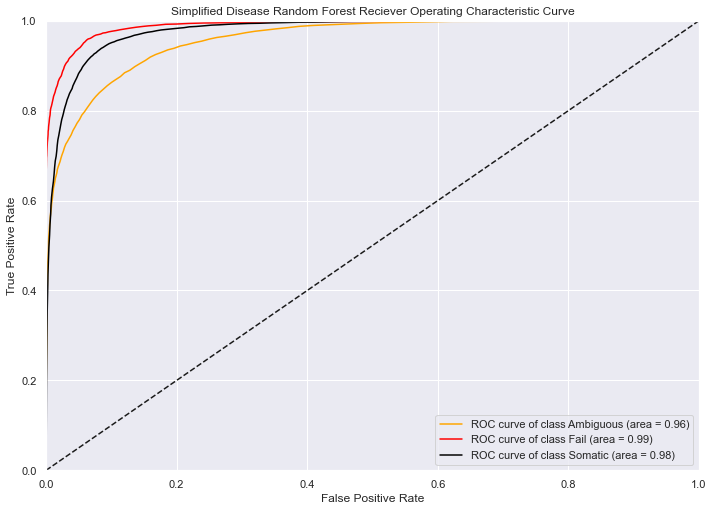

In [40]:
# Plot ROC curves 
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
fig, ax = plt.subplots()
create_roc_curve(Y_one_hot, probabilities, class_lookup, 'Simplified Disease '
                 'Random Forest Reciever Operating Characteristic Curve', ax)

confidence intervals +-:  [0.00089441 0.00332406 0.0059808  0.00798433 0.00949285 0.00986949
 0.00881704 0.00673054 0.00402426 0.00076266]


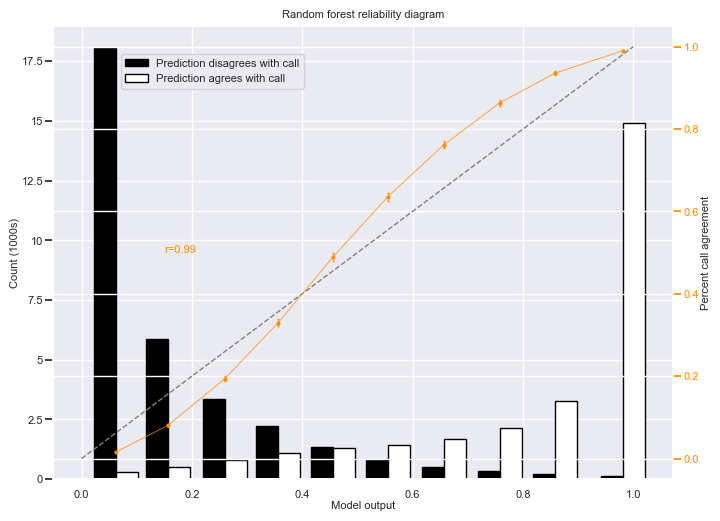

In [41]:
# Plot reliability diagram
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
lgd = create_reliability_diagram(probabilities, Y_one_hot,['Ambiguous','Fail','Somatic'], 'darkorange', 'Random forest reliability diagram',
                                 ax, True, True, True)
lgd.set_bbox_to_anchor((0.1, .85))

### Test set performance

In [42]:
#Get probabilites for hold out test set
forest = estimator.fit(X_train, Y_train)
test_prob = forest.predict_proba(X_test)

In [43]:
# Add labels
Y_test_labels = enc.fit_transform(Y_test)

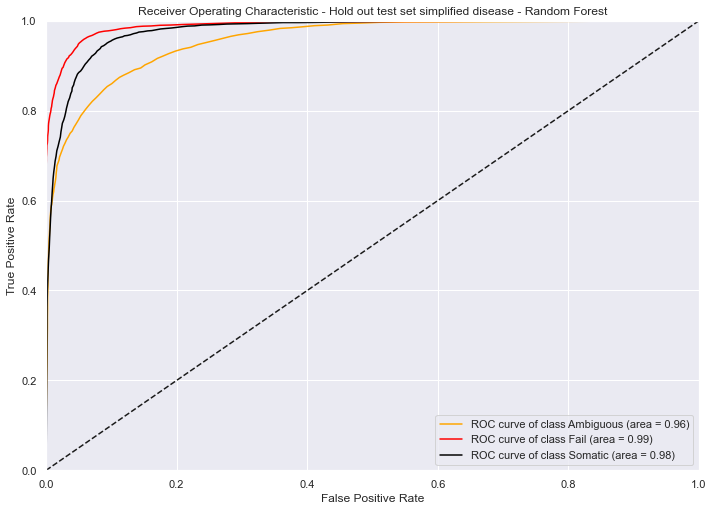

In [44]:
# PLot test set ROC
fig, ax = plt.subplots()
create_roc_curve(Y_test_labels, test_prob, class_lookup, 'Receiver Operating '
                 'Characteristic - Hold out test set simplified disease - '
                 'Random Forest', ax)

confidence intervals +-:  [0.00125467 0.00471856 0.00830475 0.01176702 0.01358045 0.01407709
 0.01229383 0.00940714 0.00557463 0.0011421 ]


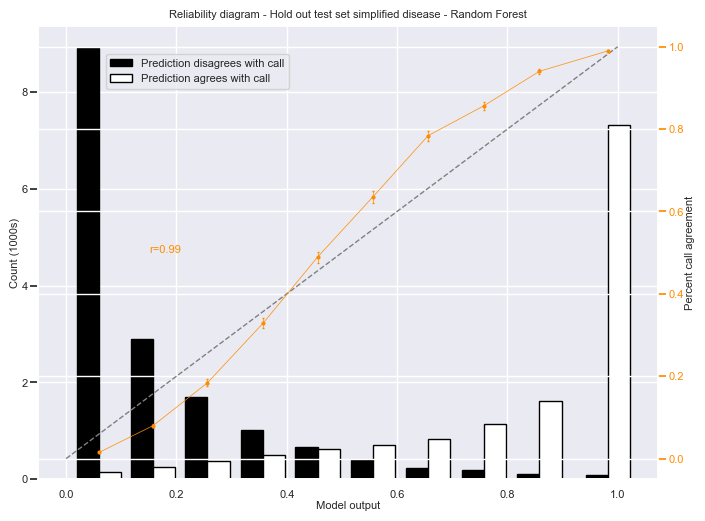

In [45]:
# Plot test set reliability diagram
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
lgd = create_reliability_diagram(test_prob, Y_test_labels,
                                 ['Ambiguous','Fail','Somatic'], 
                                 'darkorange', 'Reliability diagram - Hold out test set '
                                 'simplified disease - Random Forest',
                                 ax, True, True, True)
lgd.set_bbox_to_anchor((0.1, .85))

## Remove reviewer to simulate performance on de novo datasets

In [46]:
# Get Labels
Y = three_class.call.values
# Get training data as numpy array
s_v_b.sort_index(axis=1, inplace=True)
X = s_v_b.drop(['call', 'reviewer_1', 'reviewer_2', 'reviewer_3', 
                'reviewer_4'], axis=1).astype(float).values

In [47]:
# Test shape
X.shape

(41000, 59)

In [48]:
# Test shape
Y.shape

(41000,)

In [49]:
# Predict probabilites
probabilities = cross_val_predict(estimator, X, Y, cv=kfold, method='predict_proba')

#### Classification report
* 0 = ambiguous
* 1 = fail
* 2 = somatic

In [50]:
# Print accuracy profile
enc = preprocessing.MultiLabelBinarizer()
Y_one_hot = enc.fit_transform(Y)
print_accuracy_and_classification_report(Y_one_hot, predict_classes(probabilities))

Cross validation accuracy:
	 0.8905853658536586

Cross validation classification report

              precision    recall  f1-score   support

           0       0.84      0.78      0.81     10643
           1       0.92      0.92      0.92     11976
           2       0.90      0.94      0.92     18381

   micro avg       0.89      0.89      0.89     41000
   macro avg       0.89      0.88      0.88     41000
weighted avg       0.89      0.89      0.89     41000
 samples avg       0.89      0.89      0.89     41000



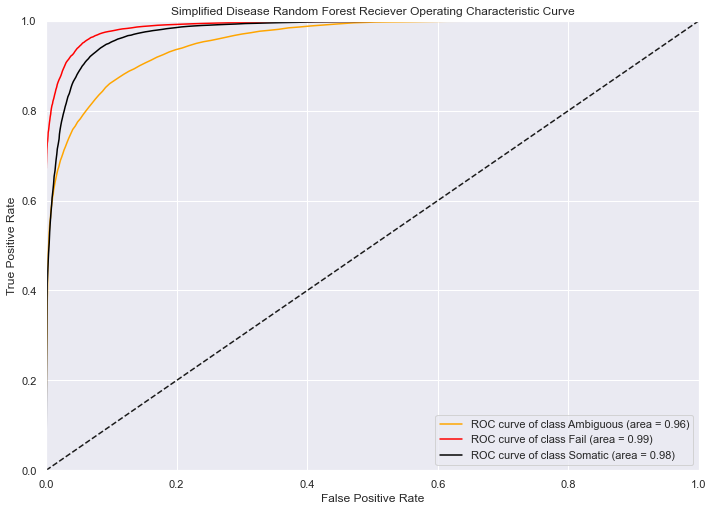

In [51]:
# Print ROC Curve for test set without reviewer
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
fig, ax = plt.subplots()
create_roc_curve(Y_one_hot, probabilities, class_lookup, 'Simplified Disease '
                 'Random Forest Reciever Operating Characteristic Curve', ax)

confidence intervals +-:  [0.00075296 0.00270697 0.00472491 0.00650511 0.00754244 0.00789358
 0.00676369 0.00519942 0.00327783 0.00064038]


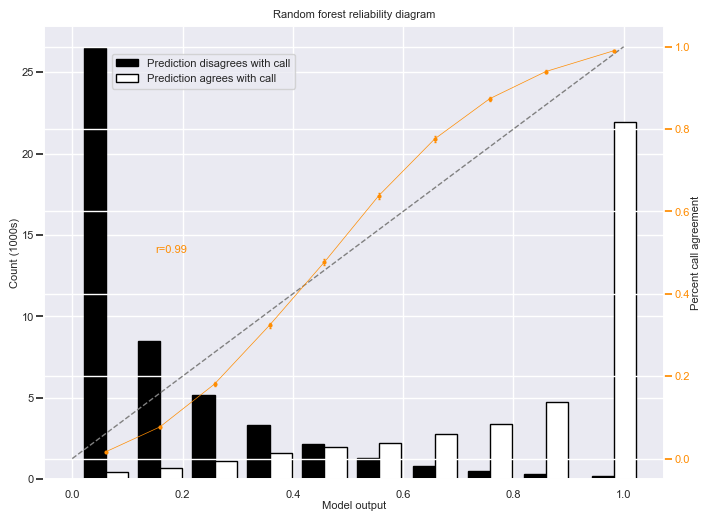

In [52]:
# Plot reliability diagram for test set without reviewer
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
lgd = create_reliability_diagram(probabilities, Y_one_hot,['Ambiguous','Fail','Somatic'], 'darkorange', 'Random forest reliability diagram',
                                 ax, True, True, True)
lgd.set_bbox_to_anchor((0.1, .85))

In [53]:
# Format probabilities and store as xval_model_results
predicted = np.array([list(a).index(max(list(a))) for a in list(probabilities)])

In [54]:
cv_somatic_error = get_somatic_error_type(Y_one_hot, predicted)

In [55]:
cv_somatic_error.index = training_data.index

In [56]:
probs_df = pd.DataFrame(probabilities, columns=['Ambiguous', 'Fail', 'Somatic'], index=training_data.index)

In [57]:
cv_somatic_error = pd.concat([cv_somatic_error, probs_df], axis=1)

In [58]:
print('remove')

remove


In [62]:
cv_somatic_error.to_pickle('deepsvr/data/random_forest/xval_model_results.pkl')

# Independent test analysis

In [63]:
# Get Labels
Y = three_class.call.values
# Get training data as numpy array
s_v_b.sort_index(axis=1, inplace=True)
X = s_v_b.drop(['call', 'reviewer_1', 'reviewer_2', 'reviewer_3', 
                'reviewer_4'], axis=1).astype(float).values

In [64]:
X.shape

(41000, 59)

In [65]:
Y.shape

(41000,)

In [66]:
forest = estimator.fit(X, Y)

In [67]:
# test oob score metrics
forest.oob_score_

0.8862926829268293

## SCLC

In [72]:
# Pull in manual review validation set (SCLC cases)
sclc_data = pd.read_pickle('deepsvr/data/independent_test/sclc_train.pkl')
# Label as solid tumor
sclc_data['solid_tumor'] = 1

In [75]:
# Pull in SCLC calls
sclc_call = pd.read_pickle('deepsvr/data/independent_test/sclc_call.pkl')
sclc_call=sclc_call.map(str.lower).replace('g','f').replace('s\x03', 's').replace('', 'f')
sclc_call.value_counts()

s    2526
f     145
a      15
Name: call, dtype: int64

In [76]:
# Get Labels
sclc_Y = sclc_call.values
# Get training data as numpy array
sclc_X = sclc_data.sort_index(axis=1).drop(['disease_SCLC', 'reviewer_Erica', 'reviewer_Lee'], axis=1).astype(float).values

In [77]:
# Employ RF model on SCLC data
sclc_probs = forest.predict_proba(sclc_X)

In [78]:
# Print accuracy profile
sclc_Y_one_hot = enc.fit_transform(sclc_Y)
print_accuracy_and_classification_report(sclc_Y_one_hot, predict_classes(sclc_probs))

Cross validation accuracy:
	 0.8123603871928519

Cross validation classification report

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.09      0.10      0.10       145
           2       0.97      0.86      0.91      2526

   micro avg       0.81      0.81      0.81      2686
   macro avg       0.35      0.32      0.34      2686
weighted avg       0.92      0.81      0.86      2686
 samples avg       0.81      0.81      0.81      2686



In [79]:
# Save predictions
np.save('deepsvr/data/random_forest/sclc_y.npy', sclc_Y_one_hot)
np.save('deepsvr/data/random_forest/sclc_probs.npy', sclc_probs)

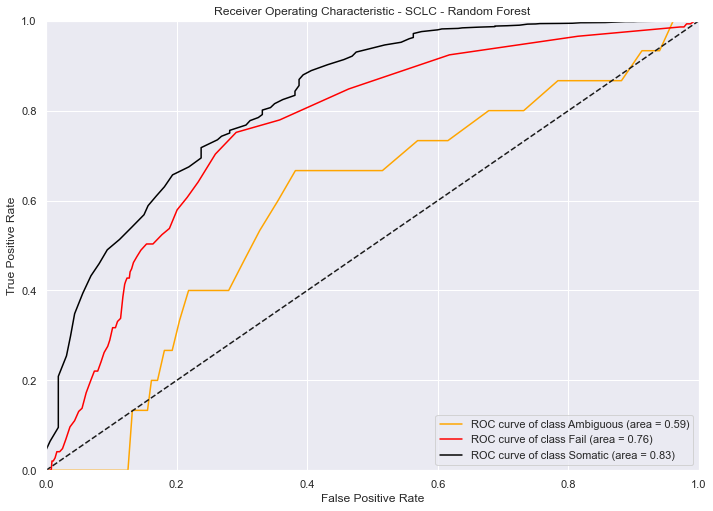

In [80]:
# Print AUC
fig, ax = plt.subplots()
create_roc_curve(sclc_Y_one_hot, sclc_probs, class_lookup, 'Receiver Operating '
                 'Characteristic - SCLC - Random Forest', ax)

## Assess how much test data is needed in training to rescue performance and compensate for batch effects

In [84]:
auc = []

for i in np.arange(0, 0.8, 0.05):
    if i == 0:
        sclc_X_test = sclc_X
        sclc_Y_test = sclc_Y
        X_train = X
        Y_train = Y
    else:
        (sclc_X_train, sclc_X_test, 
         sclc_Y_train, sclc_Y_test) = train_test_split(sclc_X, sclc_Y, 
                                                       train_size=i,
                                                       test_size=1-i,
                                                       random_state=seed, 
                                                       stratify=sclc_Y) 
        X_train = np.concatenate((X, sclc_X_train))
        Y_train = np.concatenate((Y, sclc_Y_train))
    print('Percentage of test data included in training: ', i*100)
    print('Training data shape: ', X_train.shape)
    print('Test data shape: ', sclc_X_test.shape)
    print('Number of test samples included in training: ', X_train.shape[0]-X.shape[0])
    forest = estimator.fit(X_train, Y_train)
    X_test_probs = forest.predict_proba(sclc_X_test)
    sclc_Y_test_one_hot = enc.fit_transform(sclc_Y_test)
    print_accuracy_and_classification_report(sclc_Y_test_one_hot, predict_classes(X_test_probs))
    temp_auc = []
    temp_auc.append(X_train.shape[0]-X.shape[0])
    Y_one_hot = enc.fit_transform(Y)
    for j in range(Y_one_hot.shape[1]):
        temp_auc.append(metrics.roc_auc_score(sclc_Y_test_one_hot[:, j], X_test_probs[:, j]))
    auc.append(temp_auc)
    print('Test AUC: ', temp_auc)
    print('---------------------------------------------------------')

Percentage of test data included in training:  0.0
Training data shape:  (41000, 59)
Test data shape:  (2686, 59)
Number of test samples included in training:  0
Cross validation accuracy:
	 0.7781087118391661

Cross validation classification report

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.10      0.16      0.13       145
           2       0.97      0.82      0.89      2526

   micro avg       0.78      0.78      0.78      2686
   macro avg       0.36      0.33      0.34      2686
weighted avg       0.92      0.78      0.84      2686
 samples avg       0.78      0.78      0.78      2686

Test AUC:  [0, 0.6294396605516037, 0.6682462782776262, 0.8029134501187648]
---------------------------------------------------------
Percentage of test data included in training:  5.0
Training data shape:  (41134, 59)
Test data shape:  (2552, 59)
Number of test samples included in training:  134
Cross validation 

Cross validation accuracy:
	 0.960536113179449

Cross validation classification report

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.91      0.41      0.57        73
           2       0.96      1.00      0.98      1263

   micro avg       0.96      0.96      0.96      1343
   macro avg       0.62      0.47      0.52      1343
weighted avg       0.96      0.96      0.95      1343
 samples avg       0.96      0.96      0.96      1343

Test AUC:  [1343, 0.6625320786997433, 0.9593841009599827, 0.9530433491686461]
---------------------------------------------------------
Percentage of test data included in training:  55.00000000000001
Training data shape:  (42477, 59)
Test data shape:  (1209, 59)
Number of test samples included in training:  1477
Cross validation accuracy:
	 0.9611248966087675

Cross validation classification report

              precision    recall  f1-score   support

           0      

C:\Users\fjun\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


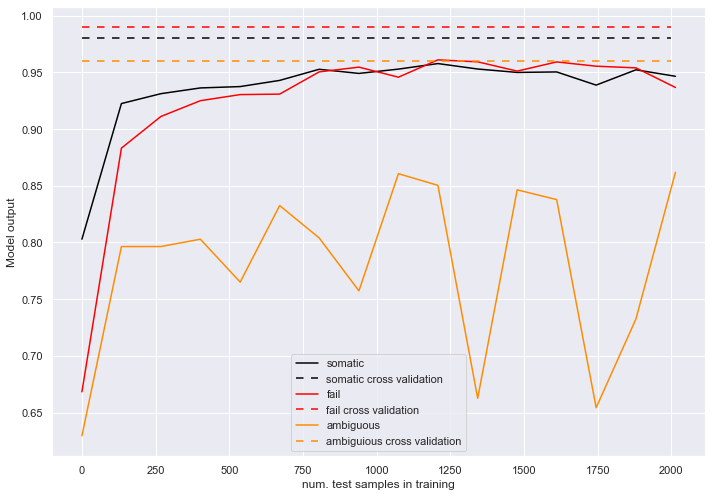

In [85]:
# Plot batch effects compensation
sclc_auc = pd.DataFrame(auc, columns=['num. test samples in training','ambiguous', 'fail','somatic'])
fig, ax = plt.subplots(1, 1)
sclc_auc.plot(x='num. test samples in training', y='somatic', ax=ax, color='black')
ax.plot([0, 2000], [.98,.98], linestyle='--', dashes=(5, 5),color='black', label='somatic cross validation')
sclc_auc.plot(x='num. test samples in training', y='fail', ax=ax, color='red')
ax.plot([0, 2000], [.99,.99], linestyle='--', dashes=(5, 5),color='red', label='fail cross validation')
sclc_auc.plot(x='num. test samples in training', y='ambiguous', ax=ax, color='darkorange')
ax.plot([0, 2000], [.96,.96], linestyle='--', dashes=(5, 5),color='darkorange', label='ambiguious cross validation')
ax.set_ylabel('Model output')
ax.legend()

In [86]:
# Save data to rf folder
sclc_auc.to_pickle('deepsvr/data/random_forest/sclc_batch_effect_correction.pkl')